# Settings

In [1]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
import soundfile as sf
import scipy
# import sys
# sys.path.append("C:/Users/HouseW/LocalPython/SATEST-main/SATEST-main/utils.py")
from utils import FrameExtractor, LPC, ref_derbin, derbin, auto_corr, PlotLPCSpectrum, ThresholdClipper
from utils import LPC_inv, PitchDetector, SignalEnergy
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('font', size=15)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=15)
plt.rc('ytick',labelsize=15)

plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=25)
plt.rc('figure', autolayout=True)

sr = 16000
win_time = 0.02
dftlen = 1024
# Window Sample의 길이 표현
win_len = int(win_time * sr)
hop_len = int(win_len * 0.5)
print("Window Len:",win_len)
print("Hop Len:",hop_len)

file_path = 'sa0_new.wav'
yr,ori_sr = lr.load(file_path,sr=sr)
time = np.linspace(0,len(yr),len(yr),endpoint=False)/sr

Window Len: 320
Hop Len: 160


## Windowing and Overlapping

In [ ]:
# ## Overlap Test

# h = lr.filters.get_window(window="hann", Nx=50)
# z = np.zeros_like(h)
# h = np.concatenate([h,z])
# h2 = np.roll(h,25)
# plt.plot(h)
# plt.plot(h2)
# plt.show()

# # h3 = h+h2+np.roll(h2,25)
# h3 = h+h2
# # print(h3)
# plt.plot(h3)
# plt.show()

# ### OLA를 하려면 hamming은 1.08배 scale이 되어야 하는구나!

# Frame Visualization In Total

In [ ]:
## 0번 frame 부터 5개를 표시해보자
""" Frame Visualization Between Total """

import math
def VisualizeFrames(signal, sr, win_len, hop_len, *frame_indices, win_type="rectangular", plot_frames=True):
    fig, ax = plt.subplots(figsize=(11, 5))
    
    # FrameExtractor 클래스의 인스턴스를 생성
    FE = FrameExtractor(signal, win_len=win_len, hop_len=hop_len)
    
    # 프레임 추출
    frame_arr = FE.extract_frames(win_type=win_type)
    
    # 시간 축 생성
    time = np.arange(0, len(signal) / sr, 1 / sr)
    
    # 기존 waveform 그리기
    ax.plot(time, signal, label='waveform')
    
    # 가변 인자로 받은 프레임 인덱스를 하나씩 처리
    for index in frame_indices:
        startind = FE.hop_len * index
        endind = startind + FE.win_len
        frame = frame_arr[index]
        ax.plot(time[startind:endind], frame, label=f'frame {index}', linestyle='--')
    
    # 축 및 타이틀 설정
    ax.set_xlabel('Time(s)', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=14)
    # ax.set_title('Frame indices: ' + ', '.join(map(str, frame_indices)), fontsize=16, fontweight='bold')
    # ax.set_title('/sa/ Signal', fontsize=16, fontweight='bold')
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlim(0, time[-1])

    ax.legend(fontsize=20, loc='lower left')
    ax.grid()

    # 확대된 프레임을 그릴 추가적인 plot 생성
    if plot_frames: 
        num_frames = len(frame_indices)
        num_cols = 1  # 1열로 설정
        num_rows = num_frames  # 프레임 개수만큼 행 설정
        
        plt.figure(figsize=[6, num_rows * 3])  # 각 행의 높이를 3으로 가정
        frame_color = ['orange','green','red','purple']
        for i, index in enumerate(frame_indices):
            start_time_ms = index * hop_len / sr * 1000
            end_time_ms = start_time_ms + win_len / sr * 1000
            time_frame_ms = np.linspace(start_time_ms, end_time_ms, win_len, endpoint=False)

            plt.subplot(num_rows, num_cols, i+1)
            frame = frame_arr[index]
            plt.plot(time_frame_ms, frame, color=frame_color[i])
            plt.grid()
            plt.xlim(start_time_ms, end_time_ms)
            plt.title(f"Frame {index}", fontsize=16)
            # if i==0:
            #     plt.title(f"Unvoiced Region (Frame {index})", fontsize=16, fontweight='bold')
            # else:
            #     plt.title(f"Voiced Region (Frame {index})", fontsize=16, fontweight='bold')
                
            plt.xlabel("Time (ms)", fontsize=12)  # 밀리초 단위로 x축 레이블 설정
            plt.ylabel("Amplitude",fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
        plt.tight_layout()  # 서브플롯 간격을 조정
    plt.show()

# VisualizeFrames(yr, sr, win_len, hop_len, 5, 10, win_type="rectangular", plot_frames=True)

## LPC Coefficients Comparision

In [ ]:
# ### librosa의 LPC와 비교하는 것
# ### LPC 계수가 올바르게 추출 되었는지 디버깅

# import librosa
# import matplotlib.pyplot as plt
# import scipy
# from utils import FrameExtractor, LPC, ref_derbin, derbin, auto_corr

# FE = FrameExtractor(yr,win_len=win_len,hop_len=hop_len)
# frame_arr = FE.extract_frames(win_type="rectangular")
# y = frame_arr[30]

# a = librosa.lpc(y, order=3)
# print(a)
# mya = LPC(y, order=3)
# drbina,e1 = ref_derbin(auto_corr(y),order=3)
# mydrbina,e2 = derbin(auto_corr(y), p=3)

# print("librosa LPC: \t\t", -1*a[1:])
# print("Matrix Inverse: \t", mya)
# print("Derbin's Inverse: \t", drbina)
# print("myDerbin's Inverse: \t", mydrbina)

hamming
From 8200 samples, total 50 frames are generated
gain: 0.028536746299844234


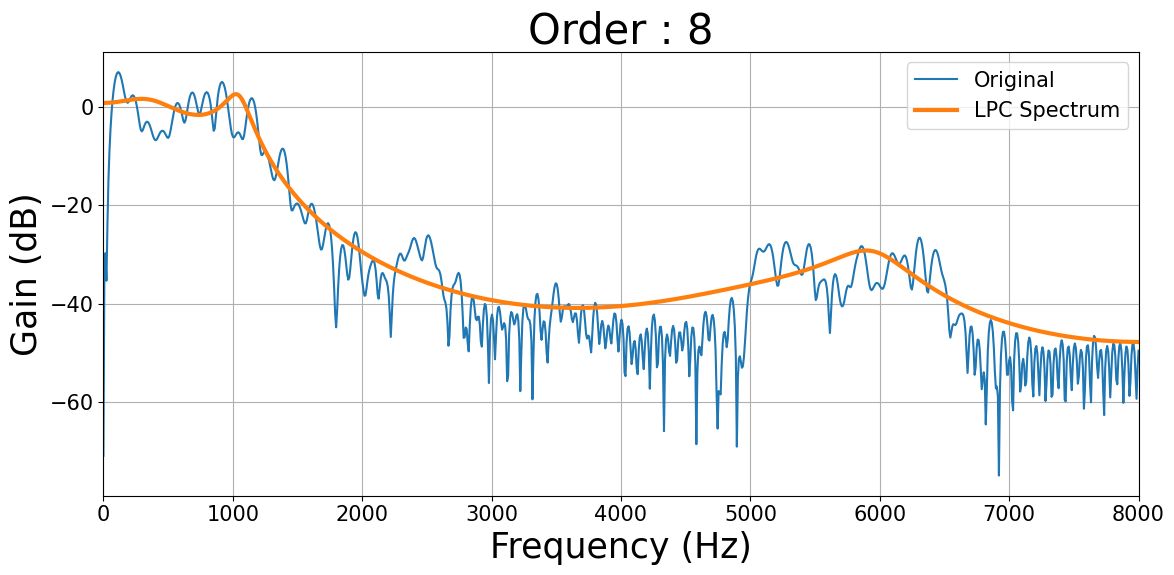

gain: 0.0245562880635076


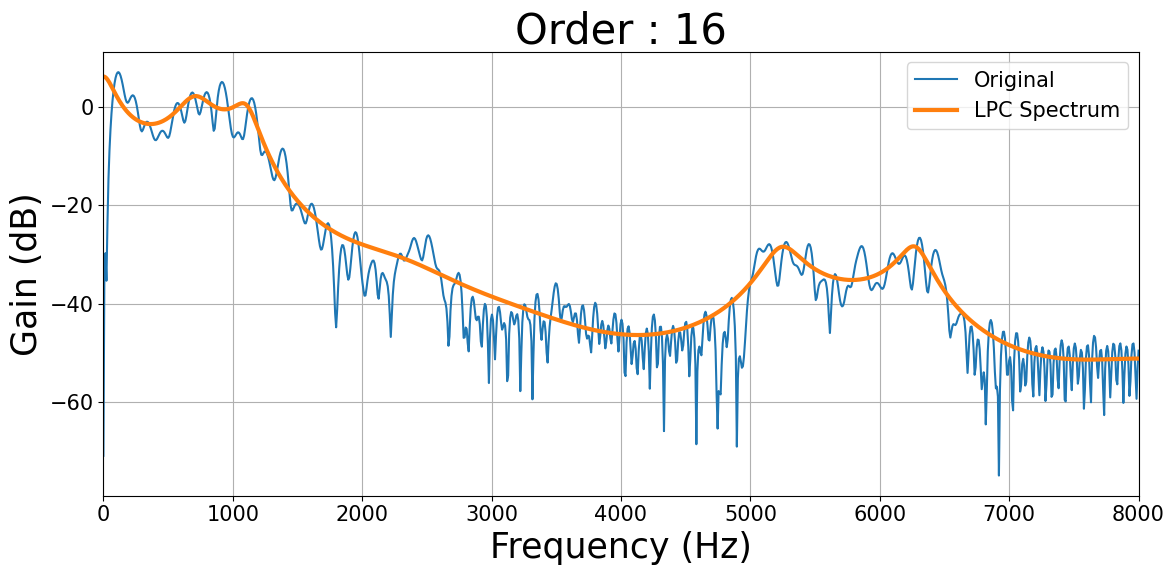

gain: 0.022992797484943497


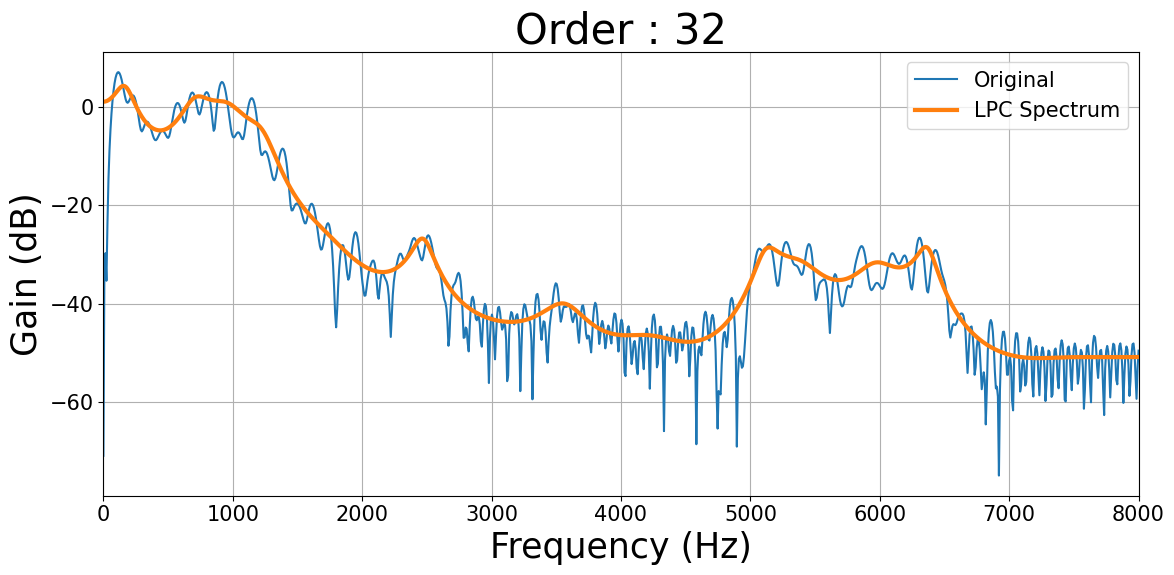

In [3]:
""" Filter의 Vocal Tract Response 추정해보기 """
## Plot LPC Spectrum
from utils import PlotLPCSpectrum

FE = FrameExtractor(yr, win_len=win_len, hop_len=hop_len)
frame_arr = FE.extract_frames(win_type="hamming")
signal = frame_arr[30]
# plt.plot(signal)
# plt.show()
PlotLPCSpectrum(signal,sr=sr,p=8,dftlen=2048)
PlotLPCSpectrum(signal,sr=sr,p=16,dftlen=2048)
PlotLPCSpectrum(signal,sr=sr,p=32,dftlen=2048)

## LPC Filtered Signal Plot

In [ ]:
""" Plot Error Signal """
## 주어진 input 신호와, 에러 신호를 그려봅시다
## Error 신호 그리기

def predict_signal(signal, coeff, order):
    lp_pred = np.zeros_like(signal)
    for m in range(len(signal)):
        pred_signal = 0  # Initialize the predicted signal for each sample
        for k in range(1, order + 1):
            if (m - k) >= 0:
                pred_signal += coeff[k-1] * signal[m - k]
        lp_pred[m] = pred_signal  # Assign the calculated prediction signal

    return lp_pred

# def residual(windowed_signal, order):
#     LPCc,_ = LPC(windowed_signal, order=order)
#     length = len(windowed_signal)
#     prediction = np.zeros((length))
#     # win_sig = np.pad(windowed_signal, order)[:-order] #앞 패딩
#     win_sig = np.pad(windowed_signal, (order, 0), 'constant', constant_values=(0, 0))
#     for k in range(length):
#         prediction[k] = np.sum(win_sig[k:k+order][::-1]*LPCc)
#     error = windowed_signal - prediction
#     return prediction, error

def PlotErrorSignal(signal, sr=16000, order=16, plot_orig=True, plot_all=True,unv=0):
    signal = signal / np.sqrt(SignalEnergy(signal))

    # LPC Analysis
    coeff,err = LPC(signal, order=order)
    coeff_T = np.concatenate(([1],-coeff))
    # print(coeff_T)
    filtered = scipy.signal.lfilter(coeff_T,[1],signal)
    # estimated = scipy.signal.lfilter(coeff,[1],signal)
    # err2 = signal - estimated
    # mse = np.sum(filtered**2)/ len(filtered)
    # mse2 = np.sum(err2**2)/ len(err2)
    mse = np.sum(err**2)/len(err)


    # """ Time Domain Processing """
    # coeff, _ = LPC(signal, order=order)
    # pred = predict_signal(signal, coeff, order=order)
    # err = signal - pred
    # mse = np.sum(err**2) / len(err)
    # # plt.plot(pred)
    # # plt.show()
    
    # """ LR """
    # a = lr.lpc(signal, order=order)
    # b = np.hstack([[0], -1 * a[1:]])
    # y_hat = scipy.signal.lfilter(b, [1], signal)
    # err = signal - y_hat
    # mse = np.sum(err**2) / len(err)
    
    
    # 입력 신호와 에러 신호(필터링된 신호) 그리기
    if plot_all:
        plt.figure(figsize=(6, 4))
        time_ms = np.arange(len(signal)) / sr * 1000
        
        # 입력 신호 플롯
        if plot_orig:
            plt.subplot(2, 1, 1)
            plt.plot(time_ms,signal, label='Input Signal')
            plt.title('Input Signal')
            plt.grid(True)
            plt.xlabel('Time (ms)',fontsize=13)
            plt.xlim(0,time_ms[-1]+0.1)
        # plt.legend()

        # 에러 신호(필터링된 신호) 플롯
        # plt.figure(figsize=(8, 6))
        plt.subplot(2, 1, 2)
        plt.plot(time_ms,filtered, label='Filtered Signal (Error Signal)')
        plt.title('Error Signal (order:{})'.format(order))
        plt.grid(True)
        # plt.legend()
        plt.xlabel('Time (ms)',fontsize=13)
        plt.xlim(0,time_ms[-1]+0.1)
        plt.ylim(-0.03,0.03)
        plt.tight_layout()
        plt.show()

        print(mse)
    return mse
################################ MAIN
FE = FrameExtractor(yr, win_len=win_len, hop_len=hop_len)
frame_arr = FE.extract_frames(win_type='hamming')
signal = frame_arr[30]

order_list = [4,8,12,16,20,24,28,32]
# order_list = [8,16,32]

mse_arr = []
for i in order_list:
    mse_arr.append(PlotErrorSignal(frame_arr[30], sr=sr, order=i, plot_orig=False, plot_all=False, unv=0))

mse_arr2 = []
for i in order_list:
    mse_arr2.append(PlotErrorSignal(frame_arr[5], sr=sr, order=i, plot_orig=False, plot_all=False, unv=1))

# plt.plot(order_list,mse_arr, marker="o",label="voiced")
# plt.plot(order_list,mse_arr2,marker="o",label="unvoiced")
# plt.grid()
# plt.xlim(order_list[0]-1,order_list[-1]+1)
# plt.xticks(order_list)
# plt.legend()
# plt.show()

plt.plot(frame_arr[30]/np.sqrt(SignalEnergy(frame_arr[30])))
plt.plot(frame_arr[5]/np.sqrt(SignalEnergy(frame_arr[5])))
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(order_list, mse_arr, marker="o", label="Voiced", color='green')
plt.plot(order_list, mse_arr2, marker="o", label="Unvoiced", color='orange')
plt.grid(True)
# plt.xscale('log', base=2)  # 로그2 스케일 적용
plt.xlabel('Order', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.title('MSE of LPC Analysis at Different Orders', fontsize=25)
# plt.xlim(order_list[0]/2, order_list[-1]*2)  # 로그 스케일에서의 x축 범위 조정
plt.xticks(order_list, labels=[str(o) for o in order_list],fontsize="20")  # 로그 스케일에서의 x축 틱 라벨 설정
plt.legend(fontsize=20)
plt.xlim(order_list[0]-1,order_list[-1]+1)
plt.show()


In [ ]:
# """
# Plot Error and Low Pass Filter
# """
# from scipy.signal import lfilter

# signal = frame_arr[30]
# # plt.plot(signal)
# # plt.show()
# ### Frame에서 진행하는 Pitch Detection

# ## 900Hz Lowpass Filering
# cutoff_freq = 900.0
# sr = 16000
# nyquist = 0.5 * sr
# num_taps = 101 # 필터의 길이

# #FIR LPF
# lpf_coeff = scipy.signal.firwin(num_taps, cutoff=cutoff_freq, fs=sr, pass_zero='lowpass', window="hamming")
# yr_lpf = scipy.signal.lfilter(lpf_coeff, 1.0, signal)

# plt.plot(yr_lpf)
# plt.show()

# ###################### 주파수 스펙트럼 plot
# filtered_signal = lfilter(lpf_coeff, 1.0, signal)

# # 주파수 스펙트럼 계산
# fft_original = np.fft.fft(signal)
# fft_filtered = np.fft.fft(filtered_signal)
# freq = np.fft.fftfreq(len(signal), 1/sr)

# # 주파수 스펙트럼 시각화
# plt.figure(figsize=(6, 4))
# plt.plot(freq, np.abs(fft_original), label='Original Signal')
# plt.plot(freq, np.abs(fft_filtered), label='Filtered Signal', linestyle='--')
# plt.title('Frequency Spectrum')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xlim(0, sr/2)  # Nyquist 주파수까지 표시
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.plot(signal)
# plt.plot(filtered_signal)
# plt.show()

In [ ]:

# """
# 각 Frame의 AutoCorrelation 뜯어보는 코드
# Pitch Detection을 더 잘하기 위함
# """
# cutoff_freq = 900.0
# sr = 16000
# order = 10
# for signal in frame_arr[15:20]:
    
#     # signal = frame_arr[30]
#     ### Frame에서 진행하는 Pitch Detection

#     ## 900Hz Lowpass Filering
#     #FIR LPF
#     lpf_coeff = scipy.signal.firwin(numtaps=101, cutoff=cutoff_freq, fs=sr, pass_zero='lowpass', window="hamming")
#     signal_lpf = scipy.signal.lfilter(lpf_coeff, 1.0, signal)

#     # plt.plot(signal_lpf)
#     # plt.show()

#     ## Frame 에서 LPC 계수 계산하기
#     coeff = LPC(signal_lpf, order=order)
#     # print(coeff)

#     ## Clipping 적용하기
#     Clipper = ThresholdClipper(signal_lpf)
#     signal_clipped = Clipper.center_clip(Clipper.CL)

#     # AC 계산하기
#     ac_arr = auto_corr(signal_clipped)

#     # Enery
#     energy = ac_arr[0]
#     voice_thres = energy * 0.4

#     # Find Peaks of AC 
#     peakval = np.max(ac_arr)    
#     maxima_indices, _ = scipy.signal.find_peaks(ac_arr)
#     maxima_indices = maxima_indices[maxima_indices>50]
    
#     if maxima_indices.size > 0:
#         maxval = np.max([ac_arr[i] for i in maxima_indices])
#         idx = np.argmax([ac_arr[i] for i in maxima_indices])
#         max_idx = maxima_indices[idx]
#     else:   
#         maxval = 0
#     flag = 1 if maxval > voice_thres else 0
#     pitch_freq = sr / max_idx if flag else 0
    
#     print(pitch_freq)
#     plt.figure(figsize=(8,1))
#     plt.plot(ac_arr)
#     plt.show()

## Definitions
## LPF, SignalEnergy, PitchDetector, PitchContour

In [ ]:
# Pitch Detector 함수 만들기
# voiced_flag : 1 if voiced, else 0
# pitch : pitch frequency if voiced, else 0
def LowPassFilter(signal, sr, cutoff=900):
    lpf_coeff = scipy.signal.firwin(numtaps=101, cutoff=900, fs=sr, pass_zero='lowpass', window="hamming")
    filtered = scipy.signal.lfilter(lpf_coeff, 1.0, signal)
    return filtered



""" 전체 signal을 넣고, 해당하는 pitch list (pitch contour)를 얻는다 """
def PitchContour(signal, win_len, hop_len, sr, plotopt=True):
    FE = FrameExtractor(signal,win_len,hop_len)
    frame_arr = FE.extract_frames(win_type="rectangular")
    
    pitchlist = []
    for framesignal in frame_arr:
        voiced_flag, pitch = PitchDetector(framesignal,sr=sr)
        pitchlist.append(pitch)
    
    # Median Filtering
    pitchlist = scipy.signal.medfilt(pitchlist, kernel_size=5)
    
    if plotopt:
        plt.figure(figsize=(15,6))
        plt.subplot(2,1,1)
        plt.plot(pitchlist)
        plt.subplot(2,1,2)
        plt.plot(signal)
        plt.show()
    return pitchlist

# SYNTHESIZE

## Definition
## LPF and Synthesis

In [ ]:
"""
Definition of Frame Synthesis
"""
## input 으로 frame을 받아, 해당 frame을 반환해보자
def Synthesis(signal, sr, pitch, p=10, plotopt = False, n=0, prev_is_voiced=0, prev_indarr=[]):
    #######################################################
    window = lr.filters.get_window("hann",Nx=len(signal))
    
    signal = signal * window
    energy = SignalEnergy(signal)
    hop_len = len(window) // 2
    
    # LPC in the Frame
    coeff = LPC(signal, order=p)
    lpc_coeff = np.concatenate(([1],-coeff))

    indarr = []
    impulse_train = np.zeros(len(signal))
    # Voiced Signals
    if pitch: 
        # 이전 frame이 voiced 인지 여부에 따라 impulse 시작점을 결정함
        current_is_voiced = 1
        samples_per_impulse = int(sr/pitch)
        
        if prev_is_voiced :
            # Voiced -> Voiced
            # 이전 index의 정보를 토대로 새로운 index를 구축함
            ## 90 190 290 있으면 제일 작도록 hop_len을 뺌
            for ind in prev_indarr:
                startind = ind - hop_len
                if startind > 0:
                    for i in range(startind,startind+len(signal), samples_per_impulse):
                        if i < len(signal):
                            indarr.append(i)
                    break
            # print(indarr, "pitch: {}".format(samples_per_impulse))
        else : 
            # Unvoiced -> Voiced 전환된 지점 
            startind = 0
            for i in range(0,len(signal), samples_per_impulse):
                if i+n < len(signal):
                    indarr.append(i+n)
            # print(indarr, "pitch: {}".format(samples_per_impulse))

        for ind in indarr:
            impulse_train[ind]=1

        tempsum = np.sum(-lpc_coeff[1:p+1] * auto_corr(signal)[1:p+1])
        gain = np.sqrt(energy - tempsum) 
        # gain = 1
        
        # plt.plot(impulse_train)
        # plt.show()

        # LPC 필터를 사용한 신호 합성
        synthesized_signal = scipy.signal.lfilter([gain], lpc_coeff, impulse_train)        

    else : # Unvoiced
        current_is_voiced = 0
        sig_std = np.std(signal)
        excitation = np.random.normal(loc=0.0, scale = sig_std, size = signal.shape)
        
        F_excitation = np.fft.fft(excitation, len(signal))
        gain = np.sqrt(energy / SignalEnergy(excitation)) 
        # gain = 1
        
        w, h = scipy.signal.freqz([gain],lpc_coeff,worN=len(signal),whole=True, fs=sr)
        F_result = F_excitation*h
        synthesized_signal = np.fft.ifft(F_result, len(signal))
        synthesized_signal = np.real(synthesized_signal)
        
    # synthesized_signal = scipy.signal.lfilter([1],lpc_coeff,F_excitation)
    
    if plotopt:
        plt.figure(figsize=(15,3))
        plt.subplot(1,2,1)
        plt.plot(synthesized_signal)
        plt.title("Synthesized Signal with LPC")

        # print(coeff)
        # filtered = lfilter(coeff,[1],signal)
        plt.subplot(1,2,2)
        plt.plot(signal)
        plt.title("Frame")
        plt.show()
        
    return synthesized_signal, current_is_voiced, indarr

In [ ]:
def LPCSynthesis(signal, win_len, hop_len, order, sr, plotopt, n=50):

    FE = FrameExtractor(signal,win_len,hop_len)
    frame_arr = FE.extract_frames(win_type="rectangular")
    synthesized = np.zeros_like(signal)

    prev_is_voiced = 0
    indarr = []
    # Pitch 
    signal = LowPassFilter(signal, sr=sr, cutoff=900)
    pitchlist = PitchContour(signal, win_len=win_len, hop_len=hop_len, sr=sr)
    
    ## 20번 frame의 신호를 정확하게 reconstruct 해볼까요?


    for i, signal in enumerate(frame_arr[:]):
        tempsig = np.zeros_like(y)
        # print("num: {}".format(i))
        start = i * hop_len
        end = start + win_len
        tempsig[start:end], prev_is_voiced, indarr = Synthesis(signal, sr=sr, pitch=pitchlist[i],p=order, plotopt=plotopt, 
                                    n = n, prev_indarr=indarr, prev_is_voiced=prev_is_voiced)
        synthesized = synthesized + tempsig
        
        ## For Debugging
        # # print(i, prev_is_voiced, indarr)
        # if prev_is_voiced: 
        #     print("Frame : {}".format(i))

    plt.figure(figsize=(15,3))
    plt.subplot(2,1,1)
    plt.plot(synthesized)
    plt.subplot(2,1,2)
    plt.plot(y)
    plt.show()

    return synthesized

## SYNTHESIZE
""" MAIN! """
file_path = "sa0_new.wav"
file_path = "yonseicrop.wav"

y,__ = lr.load(file_path,sr=sr)
synthesized = LPCSynthesis(y,win_len=win_len,hop_len=hop_len, order=25, sr=sr, plotopt=False, n=0)

import IPython.display as ipd
ipd.Audio(synthesized, rate=sr,autoplay=True)
# save_path = "synthesized_impulse_spacing_gainscale_yesLPF.wav"
# # # print(save_path)
# sf.write(save_path, synthesized, sr)

In [ ]:
# Load Data
import IPython.display as ipd
ipd.Audio(yr, rate=sr, autoplay=True)

# save_path = "synthesized.wav"
# # print(save_path)
# sf.write(save_path, synthesized, sr)